# Calculo de la distribucion de tiempos en comun

En este notebook se genera un informe sobre la distribucion de tiempos
en comun que pueden tener las observaciones hermanas.

Consideraciones:

- Nos interesa los tiempos relativos a la observacion. Por eso se usa los MJD
- Dado que los MJD son unicos al pawprint para lograr mayor eficiencia de computo
  se utilizan los ID de los pawprint para contar

In [1]:
import sys
import os
import gc
import itertools as it
import tempfile

import numpy as np
import pandas as pd

from joblib import Parallel, delayed, cpu_count, load, dump, Memory

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# corral startup
sys.path.insert(1, "/home/jbcabral/carpyncho3")
os.environ.setdefault("CORRAL_SETTINGS_MODULE", "carpyncho.settings")

from corral import core
core.setup_environment()

from corral import db
from carpyncho.models import LightCurves

/home/jbcabral/.conda/envs/carpyncho3/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
with db.session_scope() as session:
    lc = session.query(LightCurves).filter(LightCurves.tile.has(name="b396")).one()
    obs_counter = lc.obs_counter
    observations = lc.observations

[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,267] select version()
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,269] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,275] select current_schema()
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,277] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,281] SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,283] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,287] SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,288] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,294] show standard_conforming_strings
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,296] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-07 16:46:00,301] BEGIN (imp

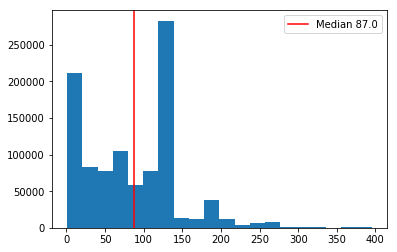

In [4]:
median = np.percentile(obs_counter["cnt"], 50)
ax = plt.gca()
ax.hist(obs_counter["cnt"], bins=20);
ax.axvline(median, color="r", label="Median " + str(median))
ax.legend()

In [5]:
obs_min = np.random.choice(
    obs_counter[obs_counter["cnt"] >= 87]["id"], 100000, False)

df = pd.DataFrame(observations[['bm_src_id', u'pwp_id']])
df = df[df.bm_src_id.isin(obs_min)]

In [6]:
%time groups = df.groupby("bm_src_id")

CPU times: user 999 µs, sys: 0 ns, total: 999 µs
Wall time: 722 µs


In [7]:
temp_folder = "./cache"
filename = os.path.join(temp_folder, 'groups.mmap')
dump(groups, filename)
groups = load(filename, mmap_mode='r+')

In [8]:
def nbg(idx, total, k1, groups):
    groups =  {k: frozenset(v["pwp_id"].values) for k, v in groups}
    g1 = groups[k1]
    results = []
    for k2, g2 in groups.iteritems():
        if k1 == k2:
            continue
        results.append(len(g1.intersection(g2)))
    print("Done {}/{}".format(idx, total))
    return np.array(results)

In [9]:
sample_size = 10000
sample = np.random.choice(obs_min, sample_size, False)
with Parallel(backend="multiprocessing", n_jobs=cpu_count(), max_nbytes=None) as jobs:
    partial = jobs(
        delayed(nbg)(idx, sample_size, k1, groups)  for idx, k1 in enumerate(sample))

Done 44/10000
Done 0/10000
Done 14/10000
Done 40/10000
Done 3/10000
Done 18/10000
Done 1/10000
Done 32/10000
Done 21/10000
Done 7/10000
Done 16/10000
Done 33/10000
Done 5/10000
Done 27/10000
Done 9/10000
Done 30/10000
Done 25/10000
Done 11/10000
Done 4/10000
Done 24/10000
Done 13/10000
Done 31/10000
Done 2/10000
Done 26/10000
Done 6/10000
Done 43/10000
Done 19/10000
Done 17/10000
Done 12/10000
Done 37/10000
Done 38/10000
Done 35/10000
Done 45/10000
Done 20/10000
Done 39/10000
Done 34/10000
Done 36/10000
Done 10/10000
Done 41/10000
Done 8/10000
Done 22/10000
Done 42/10000
Done 47/10000
Done 51/10000
Done 46/10000
Done 28/10000
Done 48/10000
Done 29/10000
Done 23/10000
Done 49/10000
Done 50/10000
Done 15/10000
Done 53/10000
Done 52/10000
Done 54/10000
Done 56/10000
Done 55/10000
Done 57/10000
Done 58/10000
Done 61/10000
Done 62/10000
Done 63/10000
Done 64/10000
Done 59/10000
Done 65/10000
Done 69/10000
Done 68/10000
Done 60/10000
Done 67/10000
Done 70/10000
Done 66/10000
Done 72/10000
Do

In [10]:
result = np.concatenate(partial)
# del partial
# gc.collect()

### Store the result to continue in another notebook

In [11]:
observations.dtype

dtype([('bm_src_id', '<i8'), ('pwp_id', '<i8'), ('pwp_stack_src_id', '<i8'), ('pwp_stack_src_hjd', '<f8'), ('pwp_stack_src_mag3', '<f8'), ('pwp_stack_src_mag_err3', '<f8')])

In [12]:
np.save("./data/count.npy", result)